In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./.gitattributes
./.gitignore
./Language-identification-LLM.ipynb
./README.md
./test.csv
./train.csv
./valid.csv
./.git\COMMIT_EDITMSG
./.git\config
./.git\description
./.git\HEAD
./.git\index
./.git\hooks\applypatch-msg.sample
./.git\hooks\commit-msg.sample
./.git\hooks\fsmonitor-watchman.sample
./.git\hooks\post-checkout
./.git\hooks\post-commit
./.git\hooks\post-merge
./.git\hooks\post-update.sample
./.git\hooks\pre-applypatch.sample
./.git\hooks\pre-commit.sample
./.git\hooks\pre-merge-commit.sample
./.git\hooks\pre-push
./.git\hooks\pre-push.sample
./.git\hooks\pre-rebase.sample
./.git\hooks\pre-receive.sample
./.git\hooks\prepare-commit-msg.sample
./.git\hooks\push-to-checkout.sample
./.git\hooks\sendemail-validate.sample
./.git\hooks\update.sample
./.git\info\exclude
./.git\lfs\cache\locks\refs\heads\rel\verifiable
./.git\lfs\objects\1e\21\1e21f10e62560b15feb46ddee48f002624c12104eb13d0915f5d092acce3ed3b
./.git\lfs\objects\20\ac\20ac2ad165e5131e1f07bf09da5f6f214f9b17b4463ab225593

In [2]:
!nvidia-smi

Sat Sep  7 19:28:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   38C    P8             14W /  170W |     810MiB /  12288MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
import urllib.request
import seaborn as sns
import plotly
import plotly.express as px
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer, fbeta_score
from sklearn.model_selection import train_test_split,cross_val_score, RepeatedStratifiedKFold
import torch
from wordcloud import WordCloud

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
data_file = "./train.csv"
try:
    df = pd.read_csv(data_file, encoding='utf-8')
except UnicodeDecodeError: # read the data with encoding since there are special or latin characters 
    try:
        df = pd.read_csv(data_file, encoding='latin-1')
    except UnicodeDecodeError:
        df = pd.read_csv(data_file, encoding='ISO-8859-1')
df.head()

,labels,text
0,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,bg,размерът на хоризонталната мрежа може да бъде ...
2,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,ru,Он увеличил давление .


In [6]:
df.shape

(70000, 2)

In [7]:
df.columns

Index(['labels', 'text'], dtype='object')

In [8]:
df.isnull().sum()

labels    0
text      0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(1020)

In [10]:
df[df.duplicated()]

,labels,text
779,pt,Comboio de Navios para o Transporte de Armas Q...
1924,pl,Kobieta kroi cebulę.
2386,pl,Silne nowe uderzenia trzęsienia ziemi roztrzas...
3634,nl,Een man speelt gitaar.
3750,pt,Um homem está a tocar guitarra.
...,...,...
69804,pl,Biały i brązowy pies biega po trawie.
69838,nl,Een zwart-witte gehoornde koe die in de wei st...
69850,it,Un treno passeggeri che entra in una stazione.
69909,bg,на обичат да правят големи пачки през един con...


In [11]:
df = df.drop_duplicates(keep = 'first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68980 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  68980 non-null  object
 1   text    68980 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [12]:
df['labels'].value_counts()

labels
ja    3500
de    3499
en    3499
es    3498
fr    3495
zh    3491
bg    3464
tr    3464
vi    3464
hi    3464
ar    3464
th    3463
el    3463
ru    3463
sw    3463
ur    3456
pt    3350
it    3346
nl    3340
pl    3334
Name: count, dtype: int64

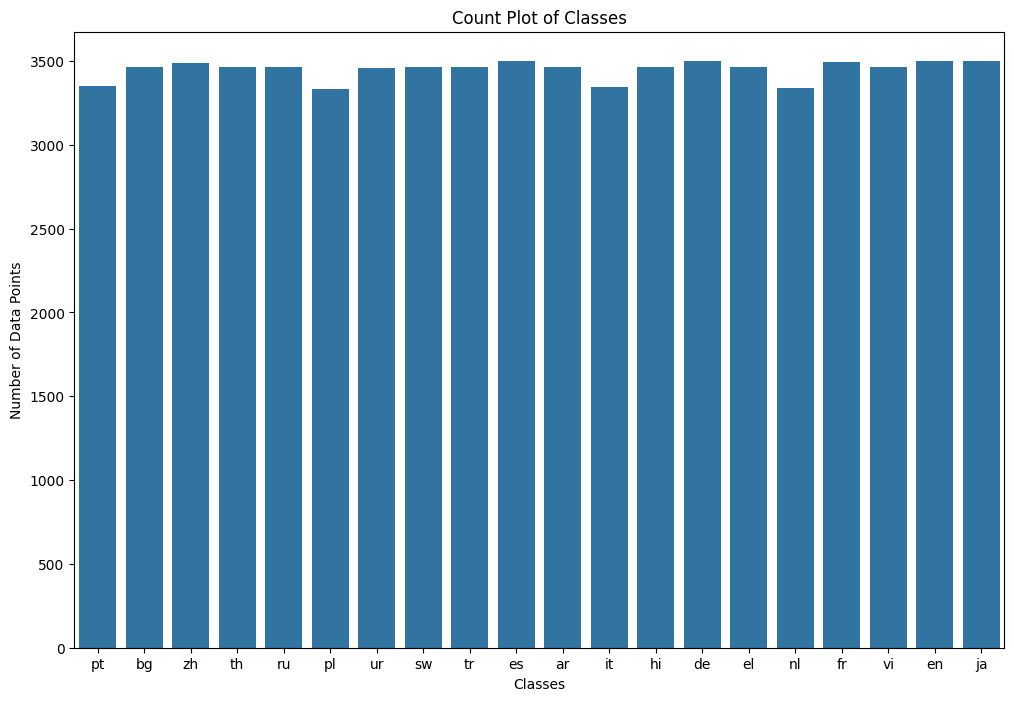

In [13]:
plt.figure(figsize=(12, 8))
fg = sns.countplot(data = df, x="labels")
fg.set_title("Count Plot of Classes")
fg.set_xlabel("Classes")
fg.set_ylabel("Number of Data Points")
plt.show()

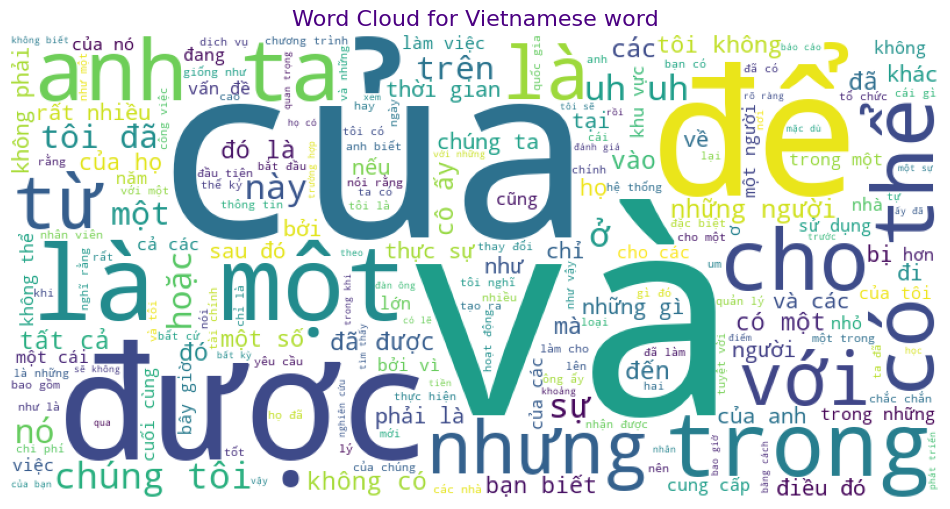

In [14]:
# Filter vài từ việt nam 
spam_texts = ' '.join(df[df['labels'] == "vi"]['text'])
# Generate a word cloud
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_texts)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud for Vietnamese word', fontsize=16, color='#4B0082')
plt.show()

In [15]:
df['length'] = df['text'].apply(len)
df.head()

,labels,text,length
0,pt,"os chefes de defesa da estónia, letónia, lituâ...",161
1,bg,размерът на хоризонталната мрежа може да бъде ...,131
2,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...,112
3,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...,141
4,ru,Он увеличил давление .,22


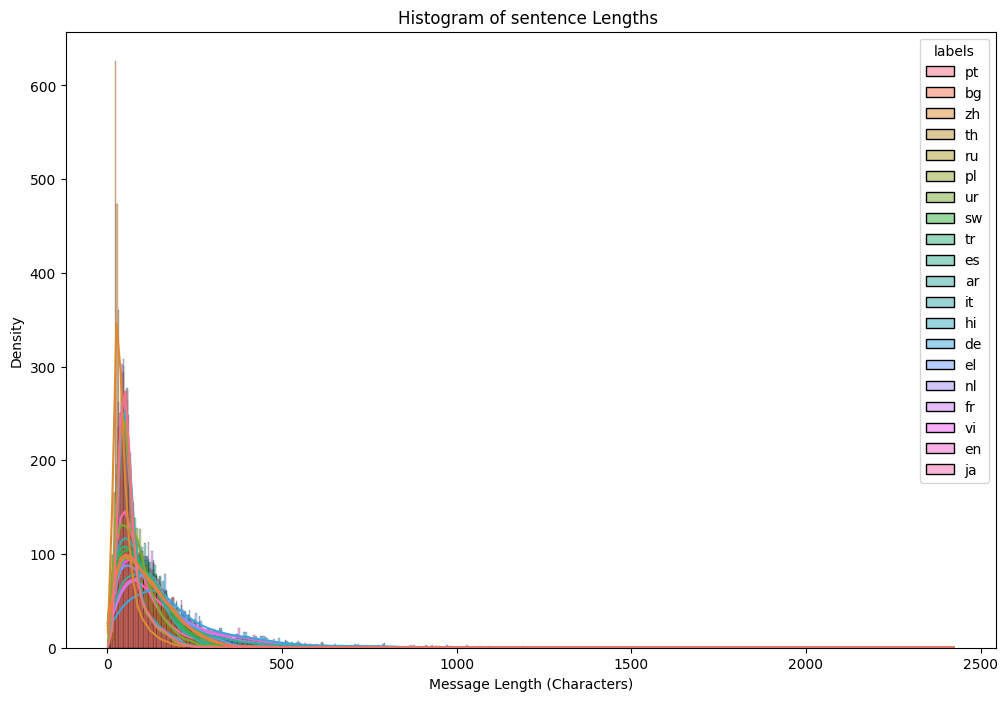

In [16]:
# Plot histogram
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='length', hue='labels', kde=True)
plt.title('Histogram of sentence Lengths ')
plt.xlabel('Message Length (Characters)')
plt.ylabel('Density')
plt.show()

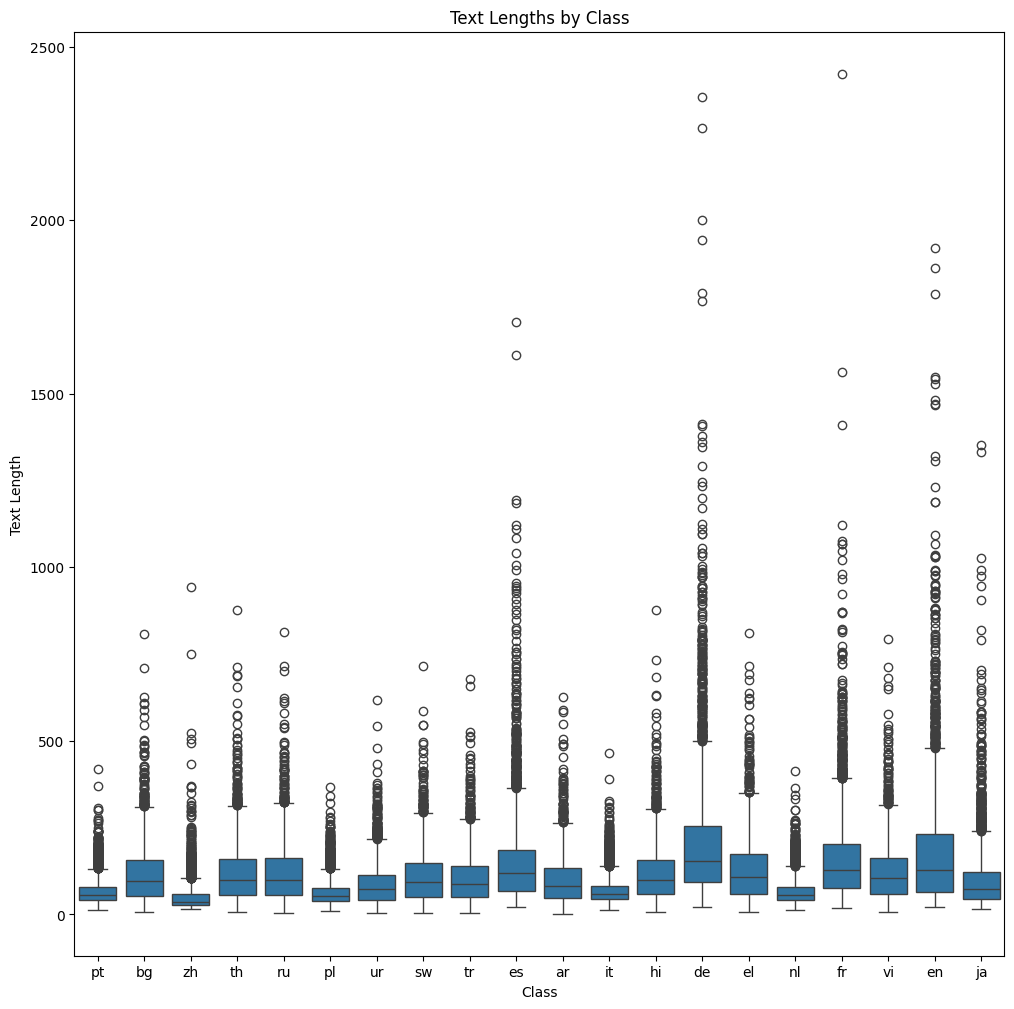

In [17]:
plt.figure(figsize=(12, 12))
sns.boxplot(x='labels', y='length', data=df)
plt.title('Text Lengths by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

In [18]:
# Loại Bỏ Nhiễu Sử Dụng Interquartile Range (IQR)

def remove_outlier_interquartile(data_sms):
    for email in data_sms["labels"].unique():
        email_type = data_sms[data_sms["labels"] == email]
        selected_column = email_type["length"]
        q1 = selected_column.quantile(0.25) 
        q3 = selected_column.quantile(0.75) 
        iqr = q3 - q1 
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr        
        outliers = selected_column[(selected_column > upper_limit) | (selected_column < lower_limit)].index 
        data_sms.drop(index = outliers, inplace=True) 

In [19]:
print(df.shape)
remove_outlier_interquartile(df)
print('after remove noise',df.shape)

(68980, 3)
after remove noise (65877, 3)


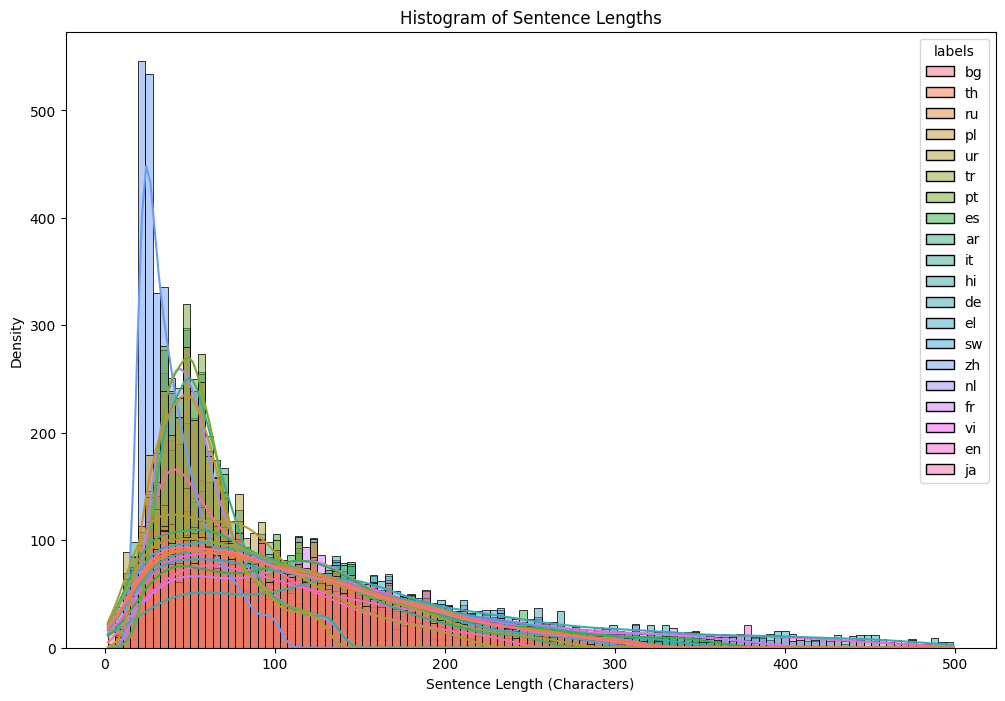

In [20]:
# Plot histogram
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='length', hue='labels', kde=True)
plt.title('Histogram of Sentence Lengths')
plt.xlabel('Sentence Length (Characters)')
plt.ylabel('Density')
plt.show()

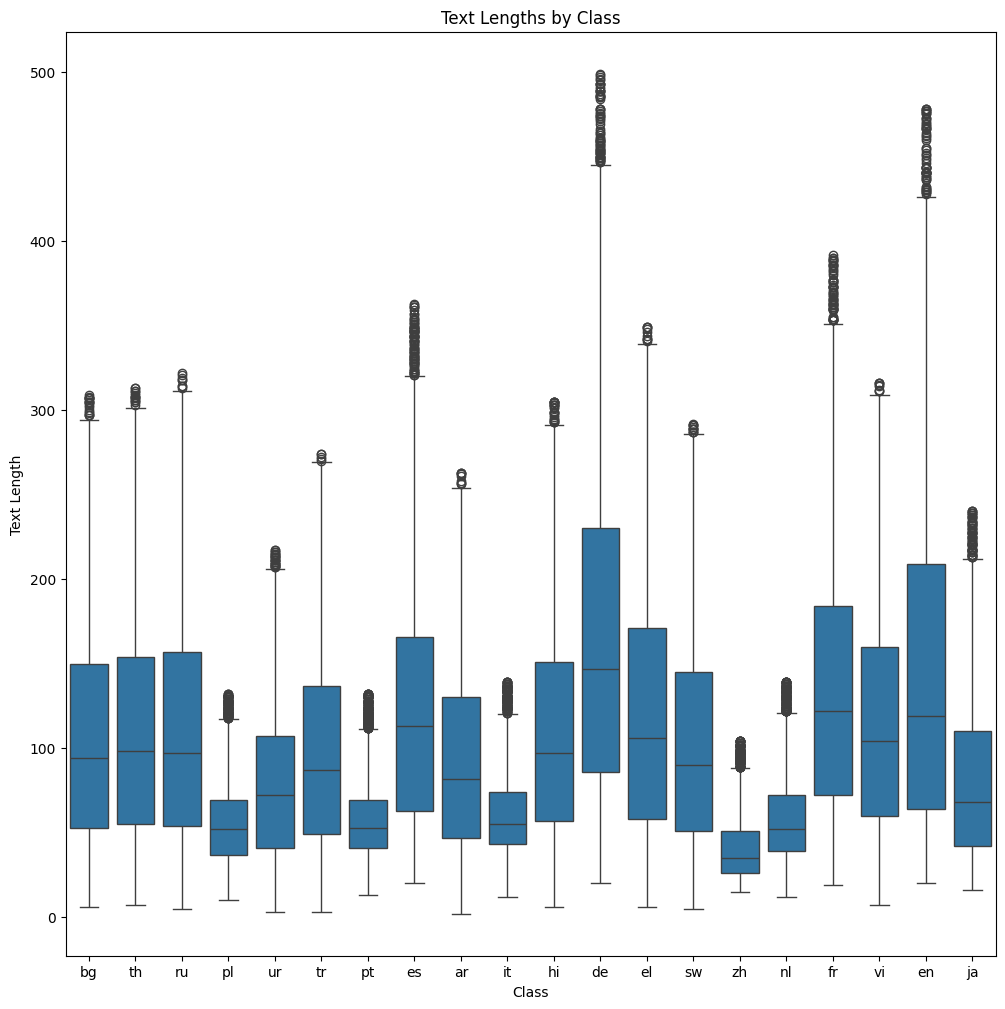

In [21]:
plt.figure(figsize=(12, 12))
sns.boxplot(x='labels', y='length', data=df)
plt.title('Text Lengths by Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

In [22]:
df = df.drop('length', axis=1)
df

,labels,text
1,bg,размерът на хоризонталната мрежа може да бъде ...
3,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,ru,Он увеличил давление .
5,pl,"S Jak sobie życzysz: Widzisz, jak Hitler zabij..."
6,ur,اس کے بارے میں ، سفید شادی کی شرح کے بعد سفید ...
...,...,...
69995,ja,本格的なゲーミングヘッドホンでした。 今まで使ってた1万円するパナソニックのヘッドホンは何だ...
69996,el,"Ναι , ξέρω ένα που είναι ακόμα έτσι , αλλά αυτ..."
69997,ur,اور مجھے اس ملک کے بارے میں معلوم نہیں ہے کہ گ...
69998,es,Se me rompió uno al sacarlo del cargador. Cali...


In [23]:
encoder = LabelEncoder()
df["labels"] = encoder.fit_transform(df["labels"])
df.head()

,labels,text
1,1,размерът на хоризонталната мрежа може да бъде ...
3,15,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,13,Он увеличил давление .
5,11,"S Jak sobie życzysz: Widzisz, jak Hitler zabij..."
6,17,اس کے بارے میں ، سفید شادی کی شرح کے بعد سفید ...


In [24]:
df["labels"].value_counts()

labels
3     3405
14    3400
0     3398
16    3397
18    3394
13    3391
1     3387
7     3386
15    3385
17    3347
4     3316
6     3310
2     3292
5     3281
9     3279
19    3215
11    3080
10    3079
12    3074
8     3061
Name: count, dtype: int64

In [46]:
encoder.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

array(['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'it', 'ja', 'nl',
       'pl', 'pt', 'ru', 'sw', 'th', 'tr', 'ur', 'vi', 'zh'], dtype=object)

In [25]:
train_df, validation_df = train_test_split(df, train_size = 0.8, stratify = df['labels'], random_state=123)
val_df, test_df = train_test_split(validation_df, train_size = 0.5, stratify = validation_df['labels'], random_state=123)

train_df = df
val_file ='./valid.csv'
test_file='./test.csv'
val_df = pd.read_csv(val_file, encoding='utf-8')
test_df = pd.read_csv(test_file,encoding='utf-8')

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(65877, 2)
(10000, 2)
(10000, 2)


In [26]:
import datasets
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# data_sets = data_sets.remove_columns(['__index_level_0__'])
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
data_sets = datasets.DatasetDict({'train':train_dataset, 'valid':valid_dataset, 'test':test_dataset})
data_sets

C:\Users\tungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 65877
    })
    valid: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [27]:
data_sets["train"].features

{'labels': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None)}

In [28]:
data_sets["train"][666]

{'labels': 1, 'text': 'сега можеш да се ожениш за богато момиче . "'}

In [29]:
#Test thử thằng này
model_names = "google-bert/bert-base-uncased"

In [30]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_names)
print(tokenizer)

BertTokenizerFast(name_or_path='google-bert/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


C:\Users\tungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [32]:
tokenizer.model_max_length

512

In [33]:
tokenizer.convert_tokens_to_ids(tokens='[CLS]')

101

In [34]:
tokenizer.convert_tokens_to_ids(tokens='[PAD]')

0

In [35]:
token_test = tokenizer.tokenize("Con mẹ chúng mày, biết bố mày là ai không ???")
print(token_test)
print(tokenizer.convert_tokens_to_ids(token_test))
print(tokenizer.decode(tokenizer.convert_tokens_to_ids(token_test)))

['con', 'me', 'chung', 'may', ',', 'bi', '##et', 'bo', 'may', 'la', 'ai', 'k', '##hong', '?', '?', '?']
[9530, 2033, 15972, 2089, 1010, 12170, 3388, 8945, 2089, 2474, 9932, 1047, 19991, 1029, 1029, 1029]
con me chung may, biet bo may la ai khong???


In [36]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = data_sets.map(tokenize_function, batched=True)

Map: 100%|██████████| 10000/10000 [00:01<00:00, 5116.11 examples/s]


In [37]:
# Xài token
train_dataset = tokenized_datasets["train"]
valid_dataset = tokenized_datasets["valid"]
test_dataset = tokenized_datasets["test"]

In [38]:
train_dataset[33]

{'labels': 18,
 'text': 'Chúng tôi đóng thuế đang sử dụng một đội quân luật sư và nhà kinh tế , người dành thời gian thức tỉnh của họ -- và có thể là một vài người trong dreamland -- Suy nghĩ về cách để có được microsoft .',
 'input_ids': [101,
  15972,
  2000,
  2072,
  1102,
  5063,
  16215,
  5657,
  1102,
  5654,
  10514,
  29328,
  9587,
  2102,
  1102,
  10448,
  24110,
  11320,
  4017,
  10514,
  12436,
  18699,
  2050,
  12631,
  2232,
  8915,
  1010,
  12835,
  19098,
  2072,
  4907,
  2232,
  27793,
  2072,
  27699,
  2078,
  16215,
  14194,
  9543,
  2232,
  12731,
  2050,
  7570,
  1011,
  1011,
  12436,
  2522,
  1996,
  2474,
  9587,
  2102,
  12436,
  2072,
  12835,
  19098,
  2072,
  19817,
  5063,
  3959,
  3122,
  1011,
  1011,
  10514,
  2100,
  12835,
  4048,
  2310,
  6187,
  2818,
  1102,
  2063,
  2522,
  1102,
  19098,
  2278,
  7513,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [39]:
print(tokenizer.decode(train_dataset[33]['input_ids']))

[CLS] chung toi đong thue đang su dung mot đoi quan luat su va nha kinh te, nguoi danh thoi gian thuc tinh cua ho - - va co the la mot vai nguoi trong dreamland - - suy nghi ve cach đe co đuoc microsoft. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [40]:
import evaluate

metrics_evaluation = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metrics_evaluation.compute(predictions=predictions, references=labels)

metrics_evaluation

EvaluationModule(name: "f1", module_type: "metric", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    labels (`list` of `int`): The set of labels to include when `average` is not set to `'binary'`, and the order of the labels if `average` is `None`. Labels present in the data can be excluded, for example to calculate a multiclass average ignoring a majority negative class. Labels not present in the data will result in 0 components in a macro average. For multilabel targets, labels are column indices. By default, all labels in `predictions` and `references` are used in sorted order. Defaults to None.
    pos_label (`int`): The class to be considered the positive class, in the case where `average` is set to `binary`. Defaults to 1.
    average (`string`): This parameter is required for multiclass/multilabel t

In [41]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    model_names, num_labels=20
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [43]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    report_to="none",
    num_train_epochs=1,
)
 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [44]:
# trainer.train()